# Importing the dependencies

In [ ]:
!pip install emoji

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import textblob
import nltk
import emoji

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier


In [ ]:
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Loading the Data
Here, we will load the data of IMDB dataset that has 50K movie reviews with their sentiment as either positive or negative.



In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/Ankit152/IMDB-sentiment-analysis/master/IMDB-Dataset.csv")
data.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [ ]:
print(f"The number of movies in the data set are : {data.shape[0]}")

The number of movies in the data set are : 50000


Let us see a few examples

In [ ]:
data["review"][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [ ]:
data["review"][102]

"I bought this game on an impulse buy from walmart. I am glad I did. It was very entertaining listening to Sean Connery and playing the game. I thought the graphics were the best I have ever seen in a movie/game remake. The bonus levels were very hard! The sniper one I think was too hard, it made me so frustrated I didn't play the game for a week and a half. There were too many people shooting at you with nothing to hide behind or life to handle it. <br /><br />The only thing I might change was the upgrade system. I didn't notice any difference from un-upgraded equipment to the upgraded, such as buying an armor upgrade didn't seem to make the armor stronger or more filling on my life meter. I really liked the Q copter. I think the developers did a good job."

In [ ]:
data["review"][49281]

"The cover art (which features a man holding a scary pellet gun) would make it seem as if it's a martial arts film. (Hardly.)<br /><br />I find it interesting that the film's real title is Trojan Warrior. (Trojan is a brand of condoms in the US) This movie is loaded with homoeroticism. If you like that stuff, then this film isn't that bad really. However, consider these points:<br /><br />There are numerous close-ups of actors' groins & butts, (One scene even features every actor with an erection bulging in his pants.) the film is also bathed in gaudy colors like lime, peach, and red. From a cinematographer's standpoint, this movie's a drag queen! Several scenes feature characters standing EXTREMELY close to one another, occasionally touching as they converse. Also, the cousin of the hero likes women, and every other guy in the movie is trying to kill him. Is there a message here the filmmakers want to convey? <br /><br />Shall I go into the fight scenes? (Yes, someone's private parts 

However, there are a few reviews which are not exactly clean. They have HTML tags inside of them and '\n' line breakers, which we can see from the examples above.

Therefore, if this data is used for any learning tasks and is given as training data, it may not be the most apt representation of real world data and the model would tend to give faulty responses. Data integrity is of core importance for any machine learning/AI task. So let us get started with the data cleaning part.

# Data Cleaning Techniques

## Lower Casing
First, it is important that we understand that a computer would process capital and small letters in the same words differently, despite them implying the same meaning. Hence to tackle this, it is always advisible to convert everything into small character based words.

In [ ]:
data["review"] = data["review"].str.lower()

In [ ]:
data["review"][2]

'i thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. the plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). while some may be disappointed when they realize this is not match point 2: risk addiction, i thought it was proof that woody allen is still fully in control of the style many of us have grown to love.<br /><br />this was the most i\'d laughed at one of woody\'s comedies in years (dare i say a decade?). while i\'ve never been impressed with scarlet johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />this may not be the crown jewel of his career, but it was wittier than "devil wears prada" and more interesting than "superman" a great comedy to go see with friends.'

## HTML Tag Removal using REGEX
We will now remove the html tags in the reviews based on the python module of **Regular Expression**, a descriptive link for which can be found [here](https://docs.python.org/3/library/re.html).

In [ ]:
def remove_html_tag(text):
  # We will create a pattern of html tags (means any content which is encapsulated between HTML tags), and then replace/substitute it with an single space string across the text
  pattern = re.compile('<.*?>')
  return pattern.sub(" ",text)

## URL Removal using REGEX
Similarly, let us now create a functionality to remove URL data should it exist in our data.

In [ ]:
def remove_url(text):
  # We will create a pattern of url string (means any content which is a URL), and then replace/substitute it with an single space string across the text
  pattern = re.compile('https?://\S+|www\.\S+')
  return pattern.sub(" ",text)

## Punctuation Removal
Similarly, let us now create a functionality to remove any punctuations,  should it exist in our data of reviews. This we will do with the help of **string** library.

In [ ]:
punctuations = string.punctuation

def remove_punc(text):
  # We will run a loop to replace all punctuations (as defined above) with a single space string in a given text
  for char in punctuations:
    text = text.replace(char," ")
  return text

## Abrevation Subsitution
Let us now create a functionality to modify any abrevations in a text to their full meaning,  should it exist in our data of reviews. This we will do with the help of giving a dictionary of potential abrevations.

In [ ]:
chat_words={
    "AFAIK":"As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP":"As Soon As Possible",
    "BTW":"By The Way",
    "B4":"Before",
    "FYI":"For your information"
}

In [ ]:
def chat_conversion(text):
    new_text=[]
    for w in text.split():
        if w.upper() in chat_words:
            new_text.append(chat_words[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

## Spelling Correction using TextBlob
Here, we will use the **TextBlob class** from the textblob library, which allows us to correct any spelling errors in out data.

In [ ]:
from textblob import TextBlob # Importing the class module from textblob

def correct_spell(text):
  instance = TextBlob(text)
  return instance.correct().string

Note that this TextBlob instance may not able to give the correct spelling for all words, as it does not entirely understand the context as in depth as some high end models.

## Stop Words
Now, there are some words which do not provide any semantic meaning to the sentence. Although they are required for the text to be cohesive and understandable, they do not neccessarily add any value to the meaning of the text, hence it is adivisble to remove them. Let us download the stopwords from the **NLTK** library.
Also, we can create our own manual list with specific stopwords to remove them, in case the current ones are insufficient.

In [ ]:
# Stopwords list for english language based text
Stopwords = stopwords.words("english")
Stopwords[:5] # Example of a few stopwords

['i', 'me', 'my', 'myself', 'we']

In [ ]:
def remove_stopwords(text):
    new_text=[]

    for word in text.split():
        if word in Stopwords:
            new_text.append(" ")
        else:
            new_text.append(word.strip())


    return " ".join(new_text).replace("   "," ")

## Emoji Handling
There may be a few cases where our textual data would be having emoticons in it. A computer or simple machine may not be able to understand it and what emotion does is exactly represent in the text.
Hence, we can remove the emojis or replace them with apporpirate representations using the **Emoji** library in python.

In [ ]:
def remove_emoji(text):
  clean_text = emoji.demojize(text)
  return clean_text

So, the representation of the emoji above will be replaced by it's english name, which can be seen in the example below :

In [ ]:
emoji.EMOJI_DATA['😊']

{'en': ':smiling_face_with_smiling_eyes:',
 'status': 2,
 'E': 0.6,
 'alias': [':blush:'],
 'de': ':lächelndes_gesicht_mit_lachenden_augen:',
 'es': ':cara_feliz_con_ojos_sonrientes:',
 'fr': ':visage_souriant_avec_yeux_rieurs:',
 'ja': ':にこにこ:',
 'ko': ':미소_짓는_눈으로_살짝_웃는_얼굴:',
 'pt': ':rosto_sorridente_com_olhos_sorridentes:',
 'it': ':faccina_con_occhi_sorridenti:',
 'fa': ':لبخند_خجالتی:',
 'id': ':wajah_tersenyum_dengan_mata_bahagia:',
 'zh': ':羞涩微笑:',
 'ru': ':довольно_улыбается:',
 'tr': ':ağzı_açık_gülme:',
 'ar': ':وجه_باسم_بعينين_باسمتين:'}

## Final Pipeline
With the above methods, we can now build a pipeline which can clean all our data and use it for processing further.

In [ ]:
def cleaning_pipeline(text):
  text = remove_html_tag(text)
  text = remove_url(text)
  text = remove_punc(text)
  text = chat_conversion(text)
  text = remove_stopwords(text)
  text = remove_emoji(text)
  return text

data["review"] = data["review"].apply(cleaning_pipeline)

Let us now view the data.

In [ ]:
data.head(10)

,review,sentiment
0,one reviewers mentioned watching 1 oz epis...,positive
1,wonderful little production filming techniqu...,positive
2,thought wonderful way spend time hot sum...,positive
3,basically family little boy jake thinks ...,negative
4,petter mattei love time money visually stu...,positive
5,probably time favorite movie story selflessn...,positive
6,sure would like see resurrection dated sea...,positive
7,show amazing fresh innovative idea 70 ...,negative
8,encouraged positive comments film lookin...,negative
9,like original gut wrenching laughter like ...,positive


# Tokenization
To train on text data, one very important concept is of **tokens**. They can be understood as a basic unit of data which is given as input and received as output. In textual data, a token represents words, subwords or characters. For now, we will perform the conversion of text to tokens via the **nltk** library

In [ ]:
from nltk.tokenize import word_tokenize,sent_tokenize
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Now say if we have a text with multiple sentences, we can convert it into **Sentence Tokens** which basically convert texts into tokens where each token represents a sentence or a chunk of the overall text. Let us see the example below :

In [ ]:
my_text = """Training and inference are two distinct phases in the lifecycle of a machine learning model.

During training, the model learns from the input data and adjusts its parameters to minimize the difference between its predictions and the actual target values. This process involves backpropagation, optimization algorithms, and iterative updates to the model's parameters.

Inference is the phase where the trained model is used to make predictions on new, unseen data. During inference, the model takes input data and generates output predictions based on the learned patterns and relationships in the training data. Inference is typically faster and less computationally intensive than training, as the model's parameters are fixed and do not need to be updated."""

In [ ]:
sent_tokenize(my_text)

['Training and inference are two distinct phases in the lifecycle of a machine learning model.',
 'During training, the model learns from the input data and adjusts its parameters to minimize the difference between its predictions and the actual target values.',
 "This process involves backpropagation, optimization algorithms, and iterative updates to the model's parameters.",
 'Inference is the phase where the trained model is used to make predictions on new, unseen data.',
 'During inference, the model takes input data and generates output predictions based on the learned patterns and relationships in the training data.',
 "Inference is typically faster and less computationally intensive than training, as the model's parameters are fixed and do not need to be updated."]

Now, we can also create **Word Tokens** for the above, as shown below :

In [ ]:
word_tokenize(my_text)

['Training',
 'and',
 'inference',
 'are',
 'two',
 'distinct',
 'phases',
 'in',
 'the',
 'lifecycle',
 'of',
 'a',
 'machine',
 'learning',
 'model',
 '.',
 'During',
 'training',
 ',',
 'the',
 'model',
 'learns',
 'from',
 'the',
 'input',
 'data',
 'and',
 'adjusts',
 'its',
 'parameters',
 'to',
 'minimize',
 'the',
 'difference',
 'between',
 'its',
 'predictions',
 'and',
 'the',
 'actual',
 'target',
 'values',
 '.',
 'This',
 'process',
 'involves',
 'backpropagation',
 ',',
 'optimization',
 'algorithms',
 ',',
 'and',
 'iterative',
 'updates',
 'to',
 'the',
 'model',
 "'s",
 'parameters',
 '.',
 'Inference',
 'is',
 'the',
 'phase',
 'where',
 'the',
 'trained',
 'model',
 'is',
 'used',
 'to',
 'make',
 'predictions',
 'on',
 'new',
 ',',
 'unseen',
 'data',
 '.',
 'During',
 'inference',
 ',',
 'the',
 'model',
 'takes',
 'input',
 'data',
 'and',
 'generates',
 'output',
 'predictions',
 'based',
 'on',
 'the',
 'learned',
 'patterns',
 'and',
 'relationships',
 'in',
 

Although the word tokens do have have some stopwords and uneccessary words, the function divides the text into a collection of words successfully.

Now, using the above we can tokenize any given corpus/document into a collection of sentences. These sentences will be needed for further processes such as **encoding** about which we will learn below.

We will be using this technique ahead coupled with one of the following approaches as explained below to pre-process our data.

# Stemming
Stemming is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form— generally a written word form. In all languages, many words originate from the same root word, which implies the same meaning, just in a different contextual use. Basically, it converts the words to their roots by the process of trimming and hence, is a relatively faster process.


For example, "fishing", "fished", "fisher" all have the same root word, "fish" and all of them are related to the root word only.


Stemming can be used in sentiment analysis, spam filtering, text classification, etc i.e. where it is important to understand the sentiment of the words.

In [ ]:
paragraph = """I have three visions for India. In 3000 years of our history, people from all over
                the world have come and invaded us, captured our lands, conquered our minds.
                From Alexander onwards, the Greeks, the Turks, the Moguls, the Portuguese, the British, the French, the Dutch, all of them came and looted us, took over what was ours.
                Yet we have not done this to any other nation. We have not conquered anyone. ear history abd tried to enforce our way of life on them.
                Why? Because we respect the freedom of others. That is why my first vision is that of freedom. I believe that India got its first vision of this in 1857, when we started the War of Independence. It is this freedom that
                My second otston for Lndure s developrent: For fLy years e have ben a developting nation.
                It is time we see ourselves as a developed nation. We are among the top 5 nations of the world in terms of GDP. We have a 10 percent growth rate in most areas. Our poverty levels are falling.
                Our achievements are being globally recognised today. Yet we lack the self-confidence to
                I nave s thand vision, ndsa nust tand up to Ene wod e, fecause etreve that untes Ehdsa
                Strong not onty as a ns tary power but atto as an coronde porer: Both tret go hand-un-hand.
                My good fortune was to have worked with three great minds.
                Dr. Vikram Sarabhai of the Dept. of space, Professor Satish Dhawan, who succeeded him and Dr. Brahm Prakash,
                father of nuclear materi I was lucky to have worked with all three of them closely and consider this the great opportunity
                I see four milestones in my career"""

# Tokenizing sentences
sentences = nltk.sent_tokenize(paragraph)
stemmer = PorterStemmer()


# Now, the above sentences are tokenized into words. We will now remove the stopwords and then apply stemming.
for i in range(sentences.__len__()):
    words = nltk.word_tokenize(sentences[i])
    words = [stemmer.stem(word) for word in words if word not in set(stopwords.words('english'))] # Basically, this will only keep those words which are not present in the stopwords corpus
    sentences[i] = ' '.join(words) # Joining the words to form a sentence

In [ ]:
sentences

['i three vision india .',
 'in 3000 year histori , peopl world come invad us , captur land , conquer mind .',
 'from alexand onward , greek , turk , mogul , portugues , british , french , dutch , came loot us , took .',
 'yet done nation .',
 'we conquer anyon .',
 'ear histori abd tri enforc way life .',
 'whi ?',
 'becaus respect freedom other .',
 'that first vision freedom .',
 'i believ india got first vision 1857 , start war independ .',
 'it freedom my second otston lndure developr : for fli year e ben developt nation .',
 'it time see develop nation .',
 'we among top 5 nation world term gdp .',
 'we 10 percent growth rate area .',
 'our poverti level fall .',
 'our achiev global recognis today .',
 'yet lack self-confid i nave thand vision , ndsa nust tand ene wod e , fecaus etrev unt ehdsa strong onti ns tari power atto corond porer : both tret go hand-un-hand .',
 'my good fortun work three great mind .',
 'dr. vikram sarabhai dept .',
 'space , professor satish dhawan , su

We can see above the original paragraph is now divided into sentences, where each word is now trimmed to their base word to further smoothen the process of understanding the context of the words.

However, here lies a small problem. The problem with stemming is that it may not return the ideal root word, as it only tries to trim it down to it's root word. It does not take referece from any dictionary and only trims it based on the data it gets.

For example, we know that the root word for "better" is "good", as they both imply the same thing. However, the stemming process may convert it into "bet" as it only trims it down.

It may even produce intermidiate root words which do not neccessarily mean anything, such as "intellig" for "intelligent".


# Lemmatization
Lemmatization is the process of grouping together the inflected forms of a word so they can be analysed as a single item, such as the word "better" which is the comparative form of "good". This basically tries to convert a word into it's meaningful base word which is known as **lemma**.

For example, it is able to convert the words "better", "great", "greatest" into "good", and hence provides a more accurate representaion of the words to their roots.

Lemmatization can be used in chatbots, question-answering systems, etc i.e. where it is important to understand the meaning of the words.

In [ ]:
paragraph = """I have three visions for India. In 3000 years of our history, people from all over
                the world have come and invaded us, captured our lands, conquered our minds.
                From Alexander onwards, the Greeks, the Turks, the Moguls, the Portuguese, the British, the French, the Dutch, all of them came and looted us, took over what was ours.
                Yet we have not done this to any other nation. We have not conquered anyone. ear history abd tried to enforce our way of life on them.
                Why? Because we respect the freedom of others. That is why my first vision is that of freedom. I believe that India got its first vision of this in 1857, when we started the War of Independence. It is this freedom that
                My second otston for Lndure s developrent: For fLy years e have ben a developting nation.
                It is time we see ourselves as a developed nation. We are among the top 5 nations of the world in terms of GDP. We have a 10 percent growth rate in most areas. Our poverty levels are falling.
                Our achievements are being globally recognised today. Yet we lack the self-confidence to
                I nave s thand vision, ndsa nust tand up to Ene wod e, fecause etreve that untes Ehdsa
                Strong not onty as a ns tary power but atto as an coronde porer: Both tret go hand-un-hand.
                My good fortune was to have worked with three great minds.
                Dr. Vikram Sarabhai of the Dept. of space, Professor Satish Dhawan, who succeeded him and Dr. Brahm Prakash,
                father of nuclear materi I was lucky to have worked with all three of them closely and consider this the great opportunity
                I see four milestones in my career"""

# Tokenizing sentences
sentences = nltk.sent_tokenize(paragraph)
lemitizer = WordNetLemmatizer()

# Now, the above sentences are tokenized into words. We will now remove the stopwords and then apply lemmatization.
for i in range(sentences.__len__()):
    words = nltk.word_tokenize(sentences[i])
    words = [lemitizer.lemmatize(word) for word in words if word not in set(stopwords.words('english'))] # Basically, this will only keep those words which are not present in the stopwords corpus
    sentences[i] = ' '.join(words) # Joining the words to form a sentence

In [ ]:
sentences

['I three vision India .',
 'In 3000 year history , people world come invaded u , captured land , conquered mind .',
 'From Alexander onwards , Greeks , Turks , Moguls , Portuguese , British , French , Dutch , came looted u , took .',
 'Yet done nation .',
 'We conquered anyone .',
 'ear history abd tried enforce way life .',
 'Why ?',
 'Because respect freedom others .',
 'That first vision freedom .',
 'I believe India got first vision 1857 , started War Independence .',
 'It freedom My second otston Lndure developrent : For fLy year e ben developting nation .',
 'It time see developed nation .',
 'We among top 5 nation world term GDP .',
 'We 10 percent growth rate area .',
 'Our poverty level falling .',
 'Our achievement globally recognised today .',
 'Yet lack self-confidence I nave thand vision , ndsa nust tand Ene wod e , fecause etreve untes Ehdsa Strong onty n tary power atto coronde porer : Both tret go hand-un-hand .',
 'My good fortune worked three great mind .',
 'Dr. Vik

As we can see above, the sentences are now brought to the accurate representations of their base/root words.

The problem with lemmatization is that it is slower than stemming as it tries to find the root word from the dictionary. This may not be possible for all words, and also it has a higher time complexity as compared to stemming.

# Stemming V/s Lemmatization - Project Approach
For our project, let us view the comparitive view of both these approaches :

#### **Stemming**

**Pros**
* Faster and more computationally efficient, especially for large datasets such as ours (50,000 reviews).
* Can be effective at capturing synonyms and reducing vocabulary size.


**Cons**
* May create nonsensical words (e.g., "better" becomes "bet").
* Might not always capture the correct morphological form (e.g., "running" becomes "run" which loses the present participle meaning)

---
#### **Lemmatization**

**Pros**
* More accurate than stemming, as it considers the context and dictionary to identify the correct base form (lemma) of a word.
* Preserves the grammatical meaning of words (e.g., "running" remains "running" and "better" becomes "good").

**Cons**
* Slower and computationally more expensive compared to stemming.
* Might require additional resources like a comprehensive dictionary.

For sentiment analysis, where capturing the emotional tone is crucial, some minor loss of accuracy from stemming might be acceptable if it translates to significant efficiency gains, especially with a large dataset. Apart from thatm the factors we should consider are :

* **Dataset size**: With 50,000 reviews, stemming's speed advantage becomes more appealing.
* **Task sensitivity**: If subtle nuances in word meaning are critical, lemmatization might be preferable. However, for sentiment analysis, the core emotional meaning is often preserved even with stemming.

Hence, we would be choosing stemming to process the data.

In [ ]:
def stemming_pipeline(review):
  words = nltk.word_tokenize(review)
  words = [stemmer.stem(word) for word in words if word]
  sentence = ' '.join(words)
  return sentence


In [ ]:
data["review"] = data["review"].apply(stemming_pipeline)

In [ ]:
data.head()

,review,sentiment
0,one review mention watch 1 oz episod hook righ...,positive
1,wonder littl product film techniqu unassum old...,positive
2,thought wonder way spend time hot summer weeke...,positive
3,basic famili littl boy jake think zombi closet...,negative
4,petter mattei love time money visual stun film...,positive


# Encoding
Now, it is important that for the machine to understand textual data, it needs to represent it as a numerical value or vector. For the machine to draw and perform a similarity search, it can only do so on numerical vectors.

## Frequency Based
Here, we will be encoding a single word/token based on it's frequency in the sample size. The methods to do so are :     

* One Hot Encoding (OHE)
* Bag of Words (BOW)
* N-Grams
* Term Frequency - Inverse Document Frequency (TF-IDF)

Let us now go ahead and explore all these.

### One Hot Encoding
This is the most simple way of converting a word to a vector. It is a binary vector representation of the words in the document,which is also known as Count Vectorization.

This returns the index of the word in the given vocabulary size. The vocabulary size is the total number of unique words in the document. The length of the vector is the vocabulary size and the index of the word in the vocabulary is marked as **1** and the rest of the indices are marked as **0**, which indicates the presence of that particular word in the overal sentence.

Let us understand this with an example using the **sklearn** library

In [ ]:
sent=[  ['the glass of milk'],
     ['the glass of juice'],
     ['the cup of tea'],
    ['I am a good boy'],
     ['I am a good developer'],
     ['understand the meaning of words'],
     ['your videos are good']]

In [ ]:
# Initilaise and flattening the sentences
ohe = OneHotEncoder(handle_unknown='ignore')

In [ ]:
# Fitting and transforming the sentences into arrays
encoded_sentences = ohe.fit_transform(sent).toarray()

In [ ]:
encoded_sentences

array([[0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.]])

Above, we have a matrix where each row represents a sentence and each column represents a word in the vocabulary. The value of each cell indicates whether the word is present in the sentence or not.

Now, a key disadvantage in using this method is that it creates a huge **sparse matrix** i.e. a representation has a lot of 0s which do not mean anything other than the negation of the presence of a particular word. Due to this, context is not retained as further processing happens.

### Bag of Words
Bag of words is a method to convert text data into numerical data. It is a way of extracting features from the text for use in machine learning algorithms.

It is called bag of words because any information about the order or structure of words in the document is discarded.
The model is only concerned with whether known words occur in the document, not where in the document. Let us see an example using the **sklearn** library.


In [ ]:
sent=['the glass of the milk',
     'the glass of the glass juice',
     'the cup of the tea the one on the table',
    'I am a good good boy',
     'I am a good developer',
     'understand the meaning of words',
     'your videos are good',]

cv = CountVectorizer()
X = cv.fit_transform(sent).toarray()

X

array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 4, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]])

In the above, each row represents a sentence while each column implies a unique word.

This **BOW** method stores the number of times a unique word has occured in a sentence. It is better than the one hot encoding method as it is easier to interpret.

However, it also has it's disadvantages. In the case of a large vocabulary, the eventuality is that we will obtain a sparse matrix for most textual data and also, this method will not be able to handle any out of vocabulary words.

A major issue here is that it does not capture the semantic meaning of words or the text, it only stores their frequency. Now, since it is only concerned with the frequency of words, it does not take into account the meaning of the words, which is important for any language based task.

### N Grams
Now, n-grams is a method to convert text data into numerical data and is similar to the method shown above, with only one key difference in it's processing.

Instead of now choosing one word at a time to create a vocabulary, here we choose **n** words to create unique pairs of n words (occuring sequentially) combined to form the words/phrases in vocabulary. A few types can be :     

* Unigram [Bag of Words] (n=1)
* Bigram (n=2)
* Trigram (n=3)


Let us see an example of a **bigram** using the **sklearn** library.


In [ ]:
sent=['the glass of the milk',
     'the glass of the glass juice',
     'the cup of the tea the one on the table',
    'I am a good good boy',
     'I am a good developer',
     'understand the meaning of words',
     'your videos are good',]

cv2 = CountVectorizer(ngram_range = (1,2)) # We set the n-gram range to make it process the words in n given pairs. Here, default is (1,1) which implies a unigram
X2 = cv2.fit_transform(sent).toarray()

X2

array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 4, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 

Now, although this can capture a bit context as it does create windown to store unique phrases, this can work for simple tasks or as a baseline approach but it may faulter on short and long term dependencies.


Hence, we would need another method which tries to further understand the context and meaning of the text.

### Term Frequency - Inverse Document Frequency (TF-IDF)
It is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.
It is often used as a weighting factor in information retrieval and text mining.

The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. With this, a word with a higher frequency in a document is implied to have a higher value and is reflected accordingly.

TF-IDF is calculated by multiplying two values:

* **Term Frequency (TF)**: This measures how often a word appears in a document.

* **Inverse Document Frequency (IDF)**: This measures how important a word is to the document collection as a whole.

It's formula is :

$$ TF * IDF$$


IDF Formula:

 $$IDF = log(\frac{N + 1}{df + 1})$$


Here,
* N is the total number of documents in the collection.
* df is the number of documents that contain the word.


Let us see an example of a **TD-IDF** using the **sklearn** library.

In [ ]:
sent=['the glass of the milk',
     'the glass of the glass juice',
     'the cup of the tea the one on the table',
    'I am a good good boy',
     'I am a good developer',
     'understand the meaning of words',
     'your videos are good',]

tfid = TfidfVectorizer()
X_TFIDF = tfid.fit_transform(sent).toarray()
X_TFIDF

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.43831983, 0.        , 0.        , 0.        , 0.52804154,
        0.32528383, 0.        , 0.        , 0.        , 0.        ,
        0.65056767, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.69821897, 0.        , 0.42057032, 0.        , 0.        ,
        0.25907948, 0.        , 0.        , 0.        , 0.        ,
        0.51815896, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.29551211, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.1820412 , 0.29551211, 0.29551211, 0.29551211, 0.29551211,
        0.72816479, 0.        , 0.        , 0.        , 0.        ],
       [0.43137947, 0.        , 0.51968052, 0.        , 0.        ,
        0.        , 0.73745773, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0

As we can see above, the words are now being captured along with their importance. However, this still does not capture context and the relationship between words as it should ideally.

# Encoding - Project Approach
In this project, our core focus is sentiment analysis. In sentiment analysis, transforming textual reviews into numerical features suitable for machine learning models is crucial. While several techniques exist, TF-IDF (Term Frequency-Inverse Document Frequency) offers distinct advantages when dealing with sentiment analysis data, especially compared to Bag-of-Words (BOW), N-grams, and One-Hot Encoding, such as :

**Focus on Important Words**
* TF-IDF goes beyond simple word frequency like BOW. It considers both how often a word appears within a review (Term Frequency) and how rare it is across all reviews (Inverse Document Frequency).
* This prioritizes words that are significant for a specific review but not overly common, leading to a more nuanced representation of sentiment.

**Handling Rare Words**
* Unlike BOW and N-grams, which can struggle with rare words, TF-IDF assigns them weight based on their overall rarity.
* This helps identify sentiment indicators that might be infrequent but hold strong emotional significance.

**Sparse Feature Representation**
* Compared to One-Hot Encoding, which creates a high-dimensional sparse matrix, TF-IDF results in a more compact representation.
* This reduces computational complexity and improves model training efficiency, especially for large datasets.

**Focus on Sentiment**:
* By emphasizing words that convey sentiment within a specific review, TF-IDF captures the emotional tone more effectively.
* This allows your machine learning model to learn the subtle differences in language that express positive, negative, or neutral sentiment.

Hence, we will be choosing **TF-IDF** for this project.

In [ ]:
tfid = TfidfVectorizer()
features = tfid.fit_transform(data['review'])

# Train Test Split

Let us now create the sentiment column.

In [ ]:
data["sentiment"].unique()

array(['positive', 'negative'], dtype=object)

In [ ]:
def sentiment_class(sentiment):
  if(sentiment=="positive"):
    return 1
  else:
    return 0


sentiment = data["sentiment"].apply(sentiment_class)

In [ ]:
# Performing the split
x_train, x_test, y_train, y_test = train_test_split(features,sentiment, test_size = 0.2, random_state = 1, shuffle = True)

In [ ]:
print(f"The number of training samples are : {x_train.shape[0]}")
print(f"The number of test samples are : {x_test.shape[0]} ")

The number of training samples are : 40000
The number of test samples are : 10000 


# Metric Selection
Before selecting a metric, let us see how our data set is distributed.

In [ ]:
data['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

As we can see, our data is a perfectly balanced data set. Since our dataset is perfectly balanced (equal number of reviews in each sentiment category - positive, negative, neutral), **F1-score** is an excellent choice for evaluating the sentiment analysis model's performance. We can say so as :


* **Balances Precision and Recall**:
  * F1-score is the harmonic mean of precision and recall. This means it takes both metrics into account and provides a single score that reflects the model's ability to identify true positives while minimizing false positives and false negatives.

* **Focus on Overall Performance**:
  * In a balanced dataset, F1-score directly reflects the model's accuracy in correctly classifying reviews across all sentiment categories. It avoids the potential pitfalls of focusing solely on precision or recall.

* **Clear Interpretation**:
  * A high F1-score indicates that the model performs well on both identifying relevant reviews (high recall) and avoiding misclassifications (high precision).

# Model Selection
Here, we will perform with model selection on multiple classification models and will perform comparitive analysis to select our final model. Now, instead of apporaching all possible classification models, we will go with the following hybrid approach :     


* **Start with a few well-suited models**
  * Here, we will choose 3-5 models commonly used for sentiment analysis with justifications for each
* **Training and evaluate these models**
  * This gives us a baseline performance and insights into your data's characteristics.
* **Additional models**
  * If the initial models perform poorly, we might want to explore a few more with justifications based on some findings.

So to begin with, let us start with a few models :

1. **Logistic Regression**: Interpretable and works well with TF-IDF features.

2. **Support Vector Machine (SVC)**: Powerful for handling high-dimensional data and non-linear relationships.

3. **Naive Bayes (MultinomialNB)**: Simple, efficient, and often performs well for text classification tasks.

4. **Random Forest**: Robust to overfitting and can handle complex data.

5. **XGBoost**: Powerful ensemble method for achieving high accuracy.

In [ ]:
#Creating dictionary to store model scores
scores_train = dict()
scores_test = dict()

## Logistic Regression

In [ ]:
lr = LogisticRegression()
lr.fit(x_train,y_train)
y_pred_lr = lr.predict(x_test)
y_pred_lr_train = lr.predict(x_train)

f1_lr_train = f1_score(y_train,y_pred_lr_train)
f1_lr_test = f1_score(y_test,y_pred_lr)

In [ ]:
scores_train["Logistic Regression"] = f1_lr_train
scores_test["Logistic Regression"] = f1_lr_test

print(f"The score on training data is : {f1_lr_train}")
print(f"The score on test data is : {f1_lr_test}")

The score on training data is : 0.8790688498717697
The score on test data is : 0.8666799125769918


## Support Vector Classifier (SVC)

In [ ]:
svc = SVC()
svc.fit(x_train,y_train)
y_pred_svc = svc.predict(x_test)
y_pred_svc_train = svc.predict(x_train)

f1_svc_train = f1_score(y_train,y_pred_svc_train)
f1_svc_test = f1_score(y_test,y_pred_svc)

In [ ]:
scores_train["Support Vector Classifier"] = f1_svc_train
scores_test["Support Vector Classifier"] = f1_svc_test

print(f"The score on training data is : {f1_svc_train}")
print(f"The score on test data is : {f1_svc_test}")

The score on training data is : 0.9624736123183908
The score on test data is : 0.870557871749057


## Naive Bayes (Multinomial NB)

In [ ]:
mnb = MultinomialNB()
mnb.fit(x_train,y_train)
y_pred_mnb = mnb.predict(x_test)
y_pred_mnb_train = mnb.predict(x_train)

f1_mnb_train = f1_score(y_train,y_pred_mnb_train)
f1_mnb_test = f1_score(y_test,y_pred_mnb)

In [ ]:
scores_train["Multinomial NB"] = f1_mnb_train
scores_test["Multinomial NB"] = f1_mnb_test

print(f"The score on training data is : {f1_mnb_train}")
print(f"The score on test data is : {f1_mnb_test}")

The score on training data is : 0.8421621090873388
The score on test data is : 0.8361581920903954


## Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(x_train,y_train)
y_pred_rfc = rfc.predict(x_test)
y_pred_rfc_train = rfc.predict(x_train)

f1_rfc_train = f1_score(y_train,y_pred_rfc_train)
f1_rfc_test = f1_score(y_test,y_pred_rfc)

In [ ]:
scores_train["Random Forest Classifier"] = f1_rfc_train
scores_test["Random Forest Classifier"] = f1_rfc_test

print(f"The score on training data is : {f1_rfc_train}")
print(f"The score on test data is : {f1_rfc_test}")

The score on training data is : 1.0
The score on test data is : 0.8379518072289157


## XG-Boost

In [ ]:
xgbc = XGBClassifier()
xgbc.fit(x_train,y_train)
y_pred_xgbc = xgbc.predict(x_test)
y_pred_xgbc_train = xgbc.predict(x_train)

f1_xgbc_train = f1_score(y_train,y_pred_xgbc_train)
f1_xgbc_test = f1_score(y_test,y_pred_xgbc)

In [ ]:
scores_train["XG-Boost Classifier"] = f1_xgbc_train
scores_test["XG-Boost Classifier"] = f1_xgbc_test

print(f"The score on training data is : {f1_xgbc_train}")
print(f"The score on test data is : {f1_xgbc_test}")

The score on training data is : 0.9353918772740684
The score on test data is : 0.8525849335302806


Let us see how well the models perform visually.

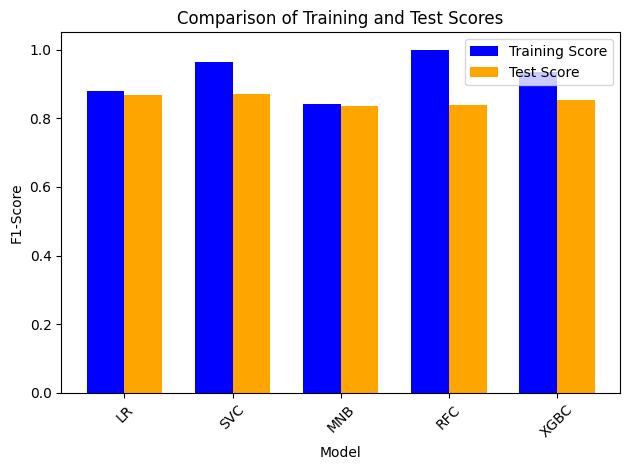

In [ ]:
models = ['LR','SVC','MNB','RFC','XGBC']
x = range(len(models))
bar_width = 0.35

plt.bar(x, scores_train.values(), bar_width, label='Training Score', color='b')

plt.bar([p + bar_width for p in x], scores_test.values(), bar_width, label='Test Score', color='orange')

plt.xlabel('Model')
plt.ylabel('F1-Score')
plt.title('Comparison of Training and Test Scores')

plt.xticks([p + bar_width / 2 for p in x], models, rotation=45)


plt.legend()
plt.tight_layout()
plt.show()

# Final Model Selection and Evaluation
From the above information, let us use the **Logistic Regression** to train on the entire data set, as it works well on both training and test data.

Also, we will use this model as it is a basic model and would demonstrate our point well.

In [ ]:
model = LogisticRegression(
    C=1.0, class_weight=None, dual=False,
    fit_intercept=True, intercept_scaling=1,
    l1_ratio=None, max_iter=100,
    multi_class='auto', n_jobs=None,
    penalty='l2', random_state=None,
    solver='lbfgs', tol=0.0001, verbose=0,
    warm_start=False
    )
model.fit(features,sentiment)

LogisticRegression()

In [ ]:
y_pred_model = model.predict(x_test)
y_pred_model_train = model.predict(x_train)

f1_model_train = f1_score(y_train,y_pred_model_train)
f1_model_test = f1_score(y_test,y_pred_model)

In [ ]:
print(f"The final score on training data is : {f1_model_train}")
print(f"The final score on test data is : {f1_model_test}")

The final score on training data is : 0.9267411950929957
The final score on test data is : 0.9268583938700368


# Conclusion
In this exploration of sentiment analysis, we've witnessed the transformative power of data pre-processing. By prioritizing text cleaning, stemming, and TF-IDF, we constructed a foundation that empowered even a simple model like Logistic Regression to achieve an impressive F1-score of 92% approximately.

This accomplishment highlights two key takeaways:

* **Pre-processing as the Cornerstone**
  * Text cleaning removes noise and inconsistencies, stemming captures word essence, and TF-IDF prioritizes relevant terms.
  * These techniques significantly enhance a model's ability to grasp the sentiment within the text data.

* **Simple Model, Strong Impact**
  * The high score achieved with LR underscores the critical role of data preparation. If a basic model can perform so well, it speaks volumes about the effectiveness of our pre-processing pipeline.

The 92% F1-score serves as a springboard for further exploration. We can delve into more complex models like LSTMs or ensemble methods like stacking to potentially push the boundaries of performance. Additionally, working with larger datasets could unlock even greater accuracy. We can see another technique in the next section.

Sentiment analysis thrives on a strong foundation of data pre-processing. By investing time in cleaning and structuring your text data, we empower our models to extract valuable insights and unlock the power of sentiment analysis.

# A Shift Towards Embeddings and advanced models

While techniques like stemming, lemmatization, bag-of-words, n-grams, and TF-IDF have been instrumental in text classification for many years, particularly in domains like spam filtering and sentiment analysis, they have a significant limitation: they fail to capture the semantic meaning of text. These methods treat words in isolation, neglecting the relationships and context that are crucial for accurate classification.

Imagine a sentence like "The bank is on the river." By simply analyzing individual words, a traditional encoding method might struggle to differentiate between a financial institution and the edge of a body of water. This is where embedding-based methods come into play. These techniques go beyond word frequency and consider the semantic relationships between words, creating a richer representation of text that can be understood by machine learning models.

The shift towards embedding-based methods for text classification represents a significant advancement in the field. By capturing the nuances of language, these techniques enable models to achieve higher accuracy and tackle more complex classification tasks. As natural language processing continues to evolve, embedding-based methods will likely play an even greater role in unlocking the true potential of text data.